# DSCI_6011_02 DEEP LEARNING 
### PROJECT BY 
## AMANI KAMBHAM AND LAKSHMI SAI KISHORE SAVARAPU

## TITLE: GENDER CLASSIFICATION AND AGE PREDICTION USING DEEP LEARNING

#### Importing necessary Modules and Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2024-04-20 21:18:34.241577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 21:18:34.241731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 21:18:34.394241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Loading the Dataset

In [2]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [5]:
len(df)

23708

In [6]:
import pandas as pd

df = df.sample(n=2000, random_state=42)

#### Exploratory Data Analysis

count    2000.000000
mean       33.461000
std        19.772885
min         1.000000
25%        24.000000
50%        30.000000
75%        45.000000
max       111.000000
Name: age, dtype: float64
gender
0    1041
1     959
Name: count, dtype: int64


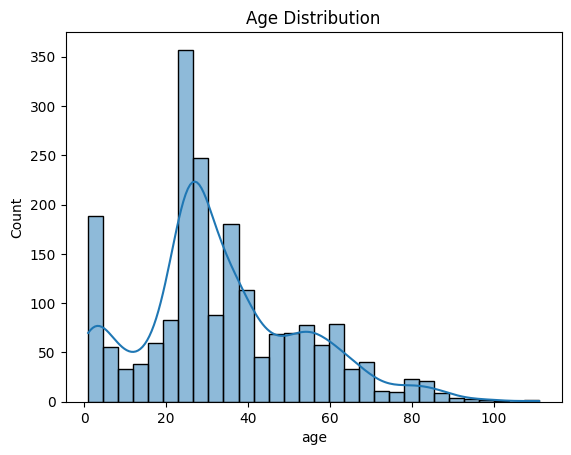

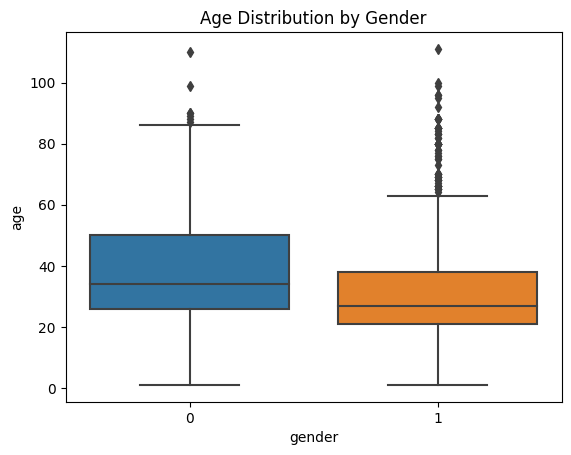

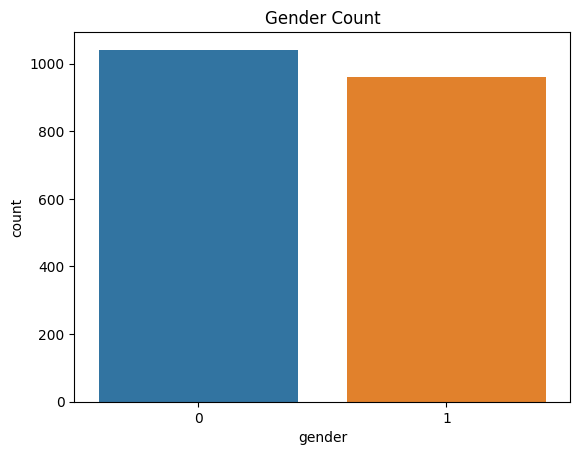

gender       0    1
age_group          
0-10       121  149
11-20       54   76
21-30      291  370
31-40      209  163
41-50      112   53
51-60      137   65
61-70       75   39
71-80       24   18
81-90       16   19
91-100       1    6


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive statistics for age
print(df['age'].describe())

# Gender distribution
print(df['gender'].value_counts())

# Age distribution
sns.histplot(data=df, x='age', bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Box plot of age by gender
sns.boxplot(data=df, x='gender', y='age')
plt.title('Age Distribution by Gender')
plt.show()

# Gender count plot
sns.countplot(data=df, x='gender')
plt.title('Gender Count')
plt.show()

# Age bins and gender distribution
df['age_group'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])
gender_age_distribution = pd.crosstab(index=df['age_group'], columns=df['gender'])
print(gender_age_distribution)


#### Filtering of Dataset images using Gaussian, Mean, Median, Weiner Filters

In [8]:
from scipy.signal import wiener
from scipy.ndimage import gaussian_filter, median_filter, uniform_filter
import cv2
import os
import pandas as pd
from tqdm.notebook import tqdm

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_gaussian_filter(image, sigma=1):
    return gaussian_filter(image, sigma=sigma)

def apply_median_filter(image, size=5):
    return median_filter(image, size=size)

def apply_mean_filter(image, size=5):
    return uniform_filter(image, size=size)

def apply_wiener_filter(image):
    return wiener(image, (5, 5))


In [9]:
def apply_filter_and_save(image, filter_func, filter_name, original_path):
    # Ensure the directory exists
    output_dir = '/kaggle/working/UTKFace_filtered/' + filter_name
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract the filename and create a new path
    filename = os.path.basename(original_path)
    new_path = os.path.join(output_dir, filename)
    
    # Apply the filter
    filtered_image = filter_func(image)
    
    # Check if image is floating point type, normalize and convert to uint8
    if filtered_image.dtype == np.float64:
        filtered_image = (filtered_image - filtered_image.min()) / (filtered_image.max() - filtered_image.min()) * 255.0
        filtered_image = filtered_image.astype(np.uint8)
    
    # If the filtered image is grayscale, ensure it has 3 channels before saving
    if len(filtered_image.shape) == 2:
        filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR)
    
    # Save the filtered image
    cv2.imwrite(new_path, filtered_image)
    
    return new_path


In [10]:
# Initialize lists to collect data
data_gaussian = []
data_mean = []
data_median = []
data_wiener = []

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_path = row['image']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply filters and save images
    gaussian_path = apply_filter_and_save(image, apply_gaussian_filter, 'gaussian', image_path)
    mean_path = apply_filter_and_save(image, apply_mean_filter, 'mean', image_path)
    median_path = apply_filter_and_save(image, apply_median_filter, 'median', image_path)
    wiener_path = apply_filter_and_save(image, apply_wiener_filter, 'wiener', image_path)
    
    # Collect data
    data_gaussian.append({'image': gaussian_path, 'age': row['age'], 'gender': row['gender']})
    data_mean.append({'image': mean_path, 'age': row['age'], 'gender': row['gender']})
    data_median.append({'image': median_path, 'age': row['age'], 'gender': row['gender']})
    data_wiener.append({'image': wiener_path, 'age': row['age'], 'gender': row['gender']})

# Convert lists to DataFrames
df_gaussian = pd.DataFrame(data_gaussian)
df_mean = pd.DataFrame(data_mean)
df_median = pd.DataFrame(data_median)
df_wiener = pd.DataFrame(data_wiener)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
import numpy as np

def display_images_from_dataframe(df, num_images=5):
    # Select a random subset of images if the DataFrame is large
    if len(df) > num_images:
        df_sample = df.sample(n=num_images)
    else:
        df_sample = df
    
    plt.figure(figsize=(15, 3 * num_images))
    
    for i, row in enumerate(df_sample.iterrows()):
        image_path = row[1]['image']
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        # Convert BGR to RGB (matplotlib expects RGB format)
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.title(f"Age: {row[1]['age']}, Gender: {'Male' if row[1]['gender'] == 0 else 'Female'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Original images


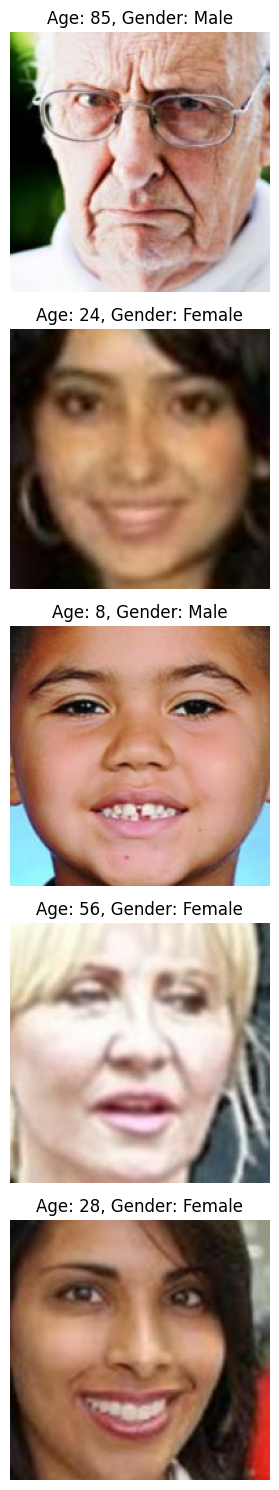

Gaussian Filtered images:


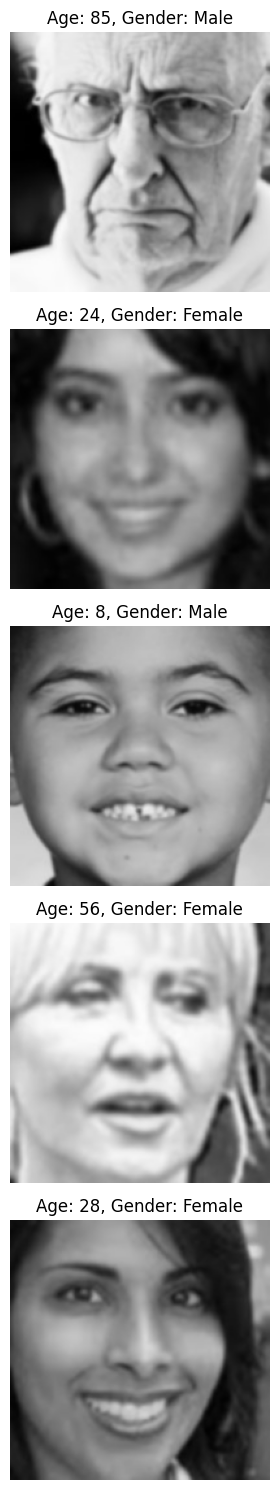

Mean Filtered images:


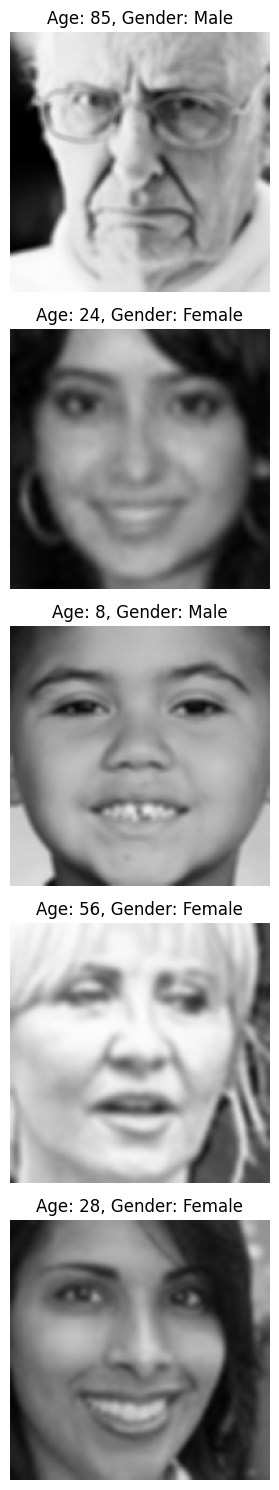

Median Filtered images:


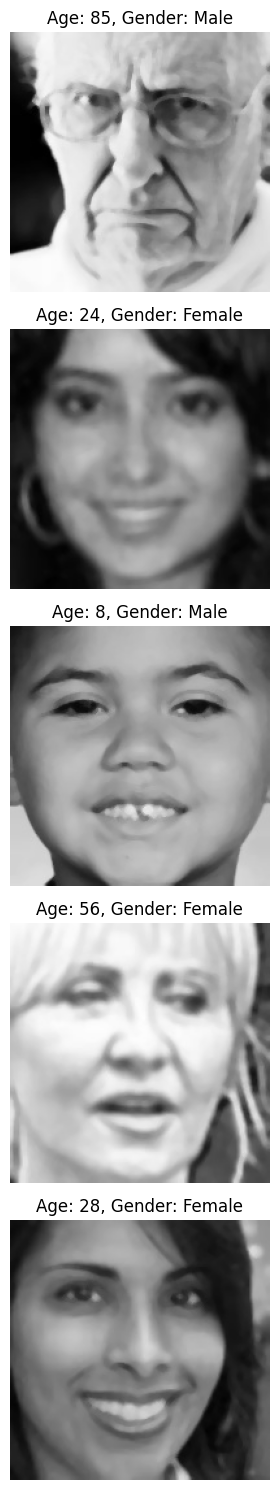

Wiener Filtered images:


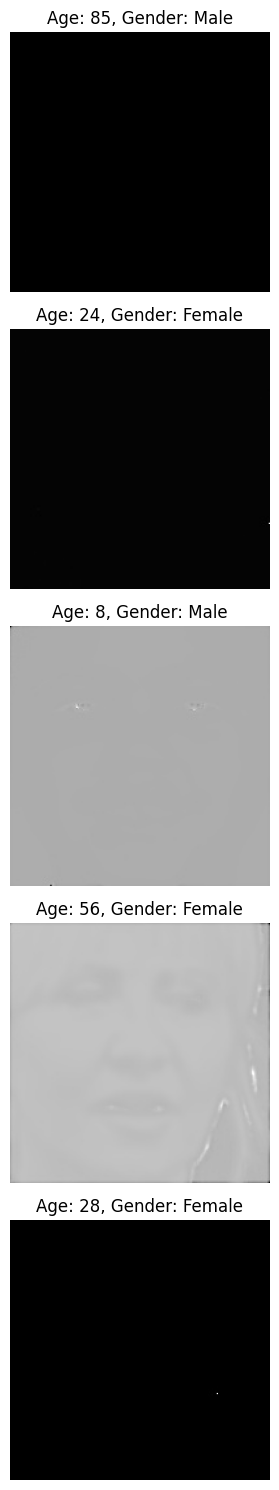

In [12]:
print('Original images')
display_images_from_dataframe(df.head(), num_images=5)
print('Gaussian Filtered images:')
display_images_from_dataframe(df_gaussian.head(), num_images=5)
print('Mean Filtered images:')
display_images_from_dataframe(df_mean.head(), num_images=5)
print('Median Filtered images:')
display_images_from_dataframe(df_median.head(), num_images=5)
print('Wiener Filtered images:')
display_images_from_dataframe(df_wiener.head(), num_images=5)


#### Evaluation of Filtered Images
##### Evaluation metrics: Structure Similarity Index, Peak Signal to Noise Ration, Mean Square Error

In [15]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim, mean_squared_error as mse
import cv2
import pandas as pd
import numpy as np


def calculate_metrics(filtered_df, original_df):
    metrics = {'PSNR': [], 'SSIM': [], 'MSE': []}
    
    # Iterate over the DataFrame using the index
    for idx in range(len(filtered_df)):
        original_image_path = original_df.iloc[idx]['image']
        filtered_image_path = filtered_df.iloc[idx]['image']
        
        # Read the original and filtered images
        original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
        filtered_image = cv2.imread(filtered_image_path, cv2.IMREAD_GRAYSCALE)
        
        # Calculate and append the metrics
        metrics['PSNR'].append(psnr(original_image, filtered_image))
        metrics['SSIM'].append(ssim(original_image, filtered_image, data_range=filtered_image.max() - filtered_image.min()))
        metrics['MSE'].append(mse(original_image, filtered_image))
    
    # Create a DataFrame from the metrics
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Calculate metrics for each DataFrame of filtered images
metrics_df_gaussian = calculate_metrics(df_gaussian, df)
metrics_df_mean = calculate_metrics(df_mean, df)
metrics_df_median = calculate_metrics(df_median, df)
metrics_df_wiener = calculate_metrics(df_wiener, df)

# Summarize and print the results for each filter type
print('Gaussian Filter Metrics Summary:')
print(metrics_df_gaussian.describe(), '\n')

print('Mean Filter Metrics Summary:')
print(metrics_df_mean.describe(), '\n')

print('Median Filter Metrics Summary:')
print(metrics_df_median.describe(), '\n')

print('Wiener Filter Metrics Summary:')
print(metrics_df_wiener.describe(), '\n')


Gaussian Filter Metrics Summary:
              PSNR         SSIM           MSE
count  2000.000000  2000.000000   2000.000000
mean      9.035331     0.370581  10499.572796
std       3.352100     0.199588   6993.393040
min       2.175036     0.000126    683.622600
25%       6.394164     0.271952   4766.423244
50%       8.587693     0.420075   9001.451087
75%      11.348878     0.510159  14916.397531
max      19.782639     0.805297  39407.309825 

Mean Filter Metrics Summary:
              PSNR         SSIM           MSE
count  2000.000000  2000.000000   2000.000000
mean      9.069576     0.379355  10450.292562
std       3.377478     0.204546   6992.844759
min       2.170437     0.000150    658.857175
25%       6.407576     0.283118   4718.512225
50%       8.610952     0.431326   8953.341925
75%      11.392753     0.521983  14870.402681
max      19.942891     0.805682  39449.059550 

Median Filter Metrics Summary:
              PSNR         SSIM           MSE
count  2000.000000  2000.0000

#### Feature Extraction

In [22]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(128, 128))
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [23]:
X = extract_features(df['image'])
X_gaussian = extract_features(df_gaussian['image'])
X_mean = extract_features(df_mean['image'])
X_median = extract_features(df_median['image'])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
print('X_shape:', X.shape)
print('X_gaussian shape:',X_gaussian.shape)
print('X_mean shape:',X_mean.shape)
print('X_median shape:',X_median.shape)

X_shape: (2000, 128, 128, 1)
X_gaussian shape: (2000, 128, 128, 1)
X_mean shape: (2000, 128, 128, 1)
X_median shape: (2000, 128, 128, 1)


In [25]:
# normalize the images
X = X/255.0
X_gaussian = X_gaussian/255.0
X_mean = X_mean/255.0
X_median = X_median/255.0

In [26]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_gaussian_gender = np.array(df_gaussian['gender'])
y_gaussian_age = np.array(df_gaussian['age'])
y_mean_gender = np.array(df_mean['gender'])
y_mean_age = np.array(df_mean['age'])
y_median_gender = np.array(df_median['gender'])
y_median_age = np.array(df_median['age'])

#### Splitting of Dataset Images

In [27]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation+test) sets (60%-40%)
X_train, X_temp, y_gender_train, y_gender_temp, y_age_train, y_age_temp = train_test_split(
    X, y_gender, y_age, test_size=0.4, random_state=42)

# Split the temp set equally into validation and test sets (50%-50% of 40% => 20%-20% of total)
X_val, X_test, y_gender_val, y_gender_test, y_age_val, y_age_test = train_test_split(
    X_temp, y_gender_temp, y_age_temp, test_size=0.5, random_state=42)


In [28]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation+test) sets (60%-40%)
X_gaussian_train, X_gaussian_temp, y_gaussian_gender_train, y_gaussian_gender_temp, y_gaussian_age_train, y_gaussian_age_temp = train_test_split(
    X_gaussian, y_gaussian_gender, y_gaussian_age, test_size=0.4, random_state=42)

# Split the temp set equally into validation and test sets (50%-50% of 40% => 20%-20% of total)
X_gaussian_val, X_gaussian_test, y_gaussian_gender_val, y_gaussian_gender_test, y_gaussian_age_val, y_gaussian_age_test = train_test_split(
    X_gaussian_temp, y_gaussian_gender_temp, y_gaussian_age_temp, test_size=0.5, random_state=42)


In [29]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation+test) sets (60%-40%)
X_mean_train, X_mean_temp, y_mean_gender_train, y_mean_gender_temp, y_mean_age_train, y_mean_age_temp = train_test_split(
    X_mean, y_mean_gender, y_mean_age, test_size=0.4, random_state=42)

# Split the temp set equally into validation and test sets (50%-50% of 40% => 20%-20% of total)
X_mean_val, X_mean_test, y_mean_gender_val, y_mean_gender_test, y_mean_age_val, y_mean_age_test = train_test_split(
    X_mean_temp, y_mean_gender_temp, y_mean_age_temp, test_size=0.5, random_state=42)


In [30]:
from sklearn.model_selection import train_test_split

# Split into training and temp (validation+test) sets (60%-40%)
X_median_train, X_median_temp, y_median_gender_train, y_median_gender_temp, y_median_age_train, y_median_age_temp = train_test_split(
    X_median, y_median_gender, y_median_age, test_size=0.4, random_state=42)

# Split the temp set equally into validation and test sets (50%-50% of 40% => 20%-20% of total)
X_median_val, X_median_test, y_median_gender_val, y_median_gender_test, y_median_age_val, y_median_age_test = train_test_split(
    X_median_temp, y_median_gender_temp, y_median_age_temp, test_size=0.5, random_state=42)


#### Model building and Evaluation
##### Convolutional Neural Network

In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layers
    age_output = Dense(1, name='age_output')(x)  # No activation for regression
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)  # Sigmoid for binary classification
    
    model = Model(inputs=input_layer, outputs=[age_output, gender_output])
    
    model.compile(optimizer='adam',
                  loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
                  metrics={'age_output': 'mae', 'gender_output': 'accuracy'})
    
    return model


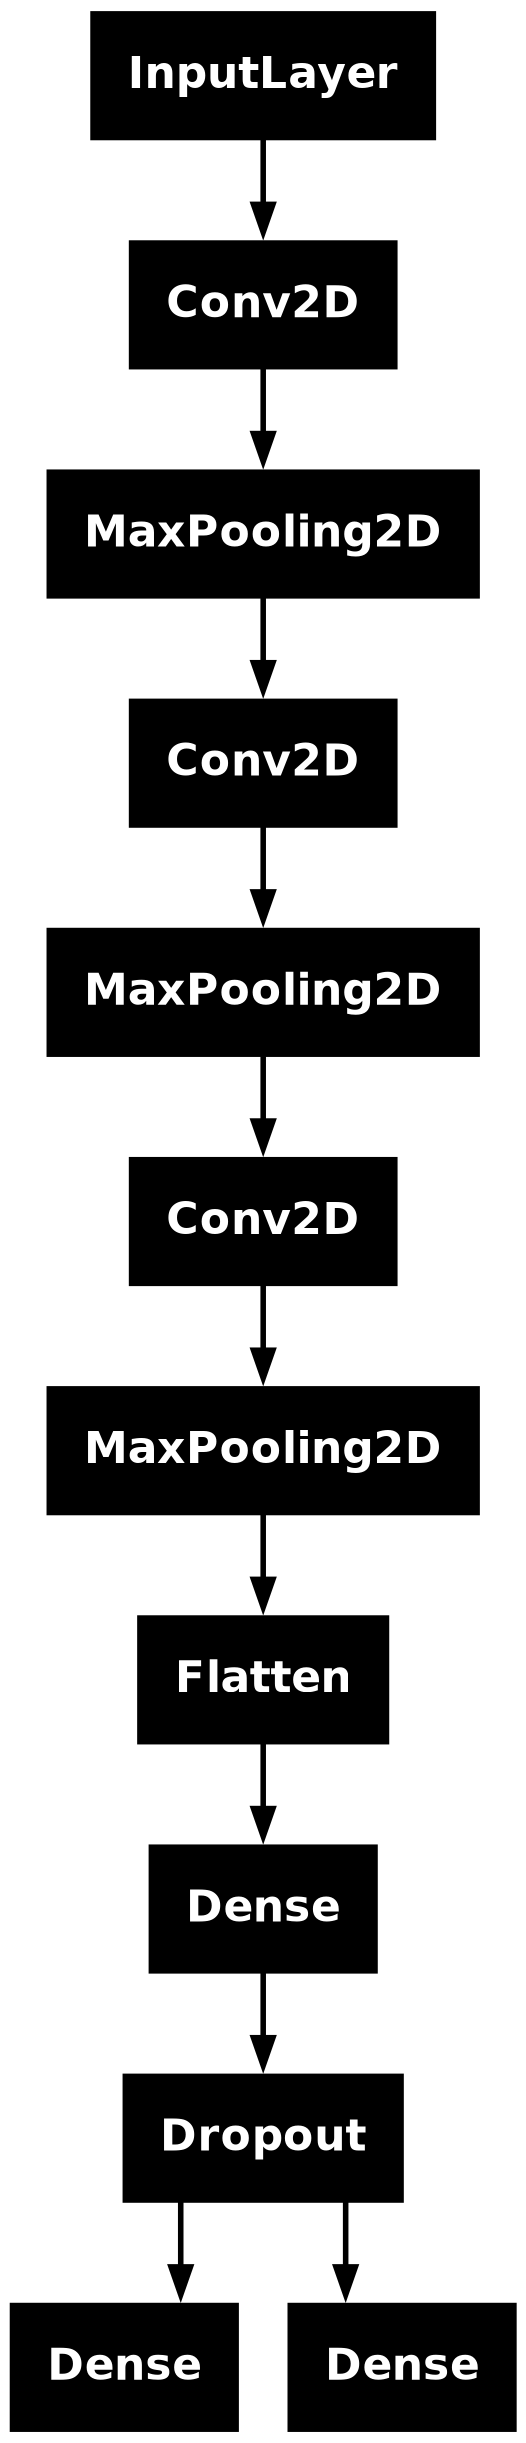

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [61]:
model = create_cnn(input_shape=(128, 128, 1))

history = model.fit(
    X_train, {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_data=(X_val, {'age_output': y_age_val, 'gender_output': y_gender_val}),
    epochs=15,  # Adjust epochs
    batch_size=32  # Adjust batch size
)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 520ms/step - age_output_mae: 23.5374 - gender_output_accuracy: 0.4890 - loss: 879.6699 - val_age_output_mae: 16.4493 - val_gender_output_accuracy: 0.5250 - val_loss: 420.3562
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - age_output_mae: 16.2400 - gender_output_accuracy: 0.5020 - loss: 456.5394 - val_age_output_mae: 15.1030 - val_gender_output_accuracy: 0.5250 - val_loss: 406.0753
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - age_output_mae: 15.1786 - gender_output_accuracy: 0.5276 - loss: 406.4993 - val_age_output_mae: 15.1929 - val_gender_output_accuracy: 0.5250 - val_loss: 379.6522
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - age_output_mae: 16.8467 - gender_output_accuracy: 0.5102 - loss: 461.8040 - val_age_output_mae: 15.2300 - val_gender_output_accuracy: 0.4750 - val_loss: 386.5683
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - age_output_mae: 15.9348 - gender_output_accuracy: 0.5076 - loss: 427.0198 - v

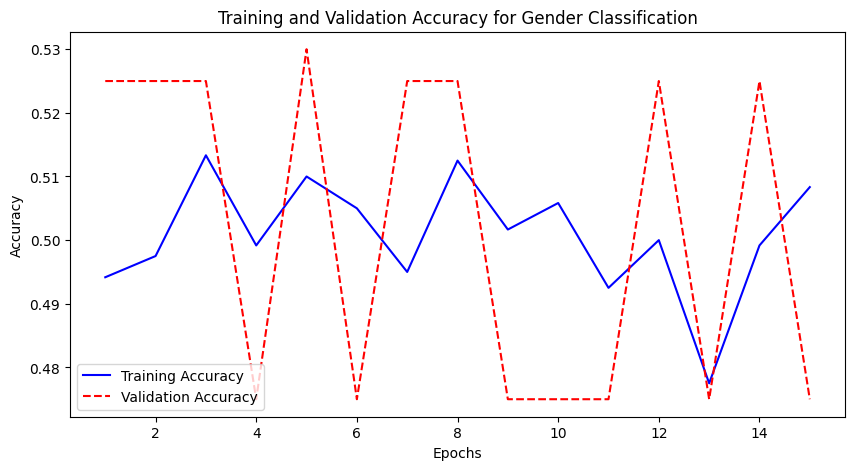

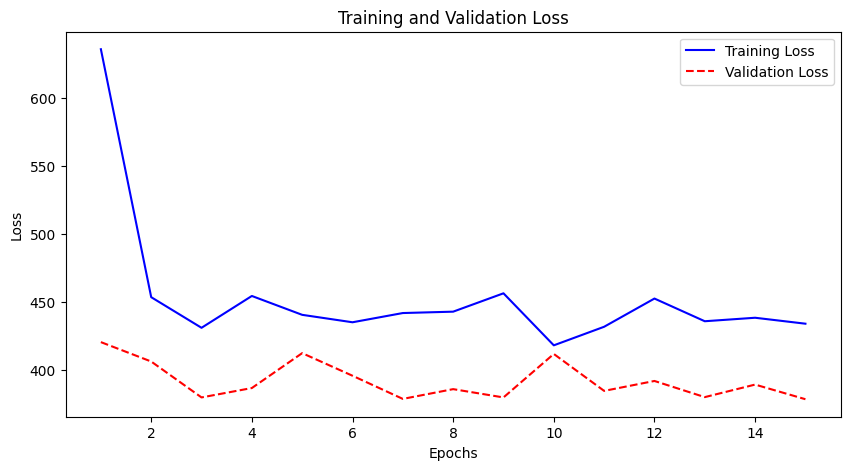

In [63]:
import matplotlib.pyplot as plt

acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


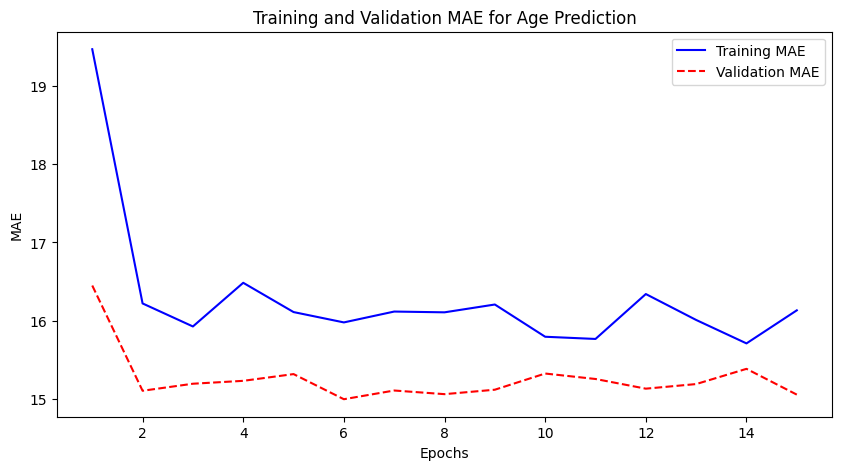

In [64]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history.history['age_output_mae']
val_loss = history.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [65]:
# Evaluate on test set
test_results = model.evaluate(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model.predict(X_test)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_gender_test, predicted_gender)
precision = precision_score(y_gender_test, predicted_gender)
recall = recall_score(y_gender_test, predicted_gender)
f1 = f1_score(y_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_age_test, predicted_age)
mae = mean_absolute_error(y_age_test, predicted_age)
r2 = r2_score(y_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - age_output_mae: 14.8054 - gender_output_accuracy: 0.5658 - loss: 360.5401
Test Loss: 368.3828430175781
Age MAE: 15.011438369750977
Gender Accuracy: 0.5674999952316284
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step

Gender Classification Metrics:
Accuracy: 0.5675, Precision: 0.0, Recall: 0.0, F1 Score: 0.0

Age Prediction Metrics:
MSE: 369.11997552024627, MAE: 15.011439895629882, R-squared: 0.004693188568440587


In [66]:
model_gauss_cnn = create_cnn(input_shape=(128, 128, 1))  

history1 = model_gauss_cnn.fit(
    X_gaussian_train, {'age_output': y_gaussian_age_train, 'gender_output': y_gaussian_gender_train},
    validation_data=(X_gaussian_val, {'age_output': y_gaussian_age_val, 'gender_output': y_gaussian_gender_val}),
    epochs=15,  # Adjust epochs
    batch_size=32  # Adjust batch size
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 528ms/step - age_output_mae: 21.7153 - gender_output_accuracy: 0.5211 - loss: 758.6165 - val_age_output_mae: 15.9971 - val_gender_output_accuracy: 0.4750 - val_loss: 438.1839
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 524ms/step - age_output_mae: 16.2756 - gender_output_accuracy: 0.5141 - loss: 457.3727 - val_age_output_mae: 15.3202 - val_gender_output_accuracy: 0.5250 - val_loss: 393.1807
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - age_output_mae: 16.8366 - gender_output_accuracy: 0.4796 - loss: 472.1119 - val_age_output_mae: 15.1254 - val_gender_output_accuracy: 0.5250 - val_loss: 390.0845
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 520ms/step - age_output_mae: 15.7552 - gender_output_accuracy: 0.4769 - loss: 428.2690 - val_age_output_mae: 14.5728 - val_gender_output_accuracy: 0.4750 - val_loss: 347.1541
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - age_output_mae: 15.2644 - gender_output_accuracy: 0.5177 - loss: 383.3250 - v

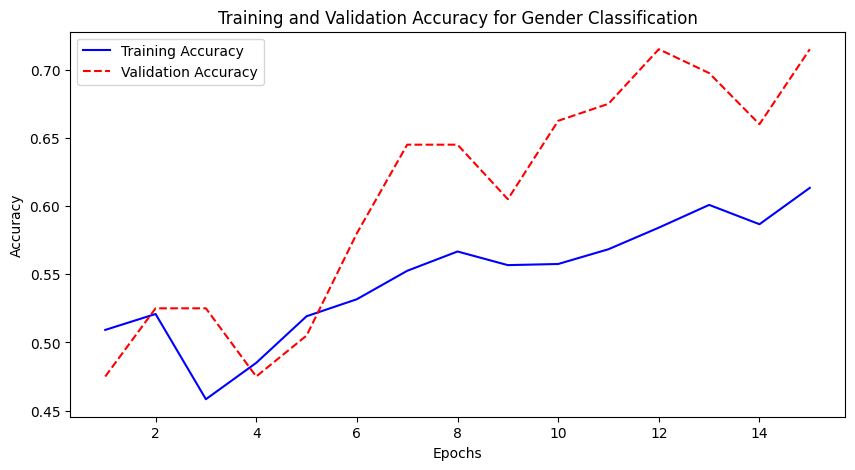

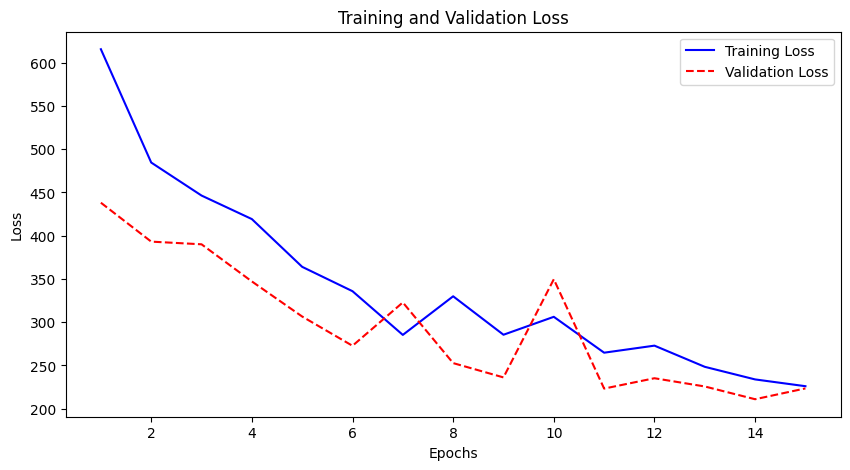

In [67]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history1.history['gender_output_accuracy']
val_acc = history1.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


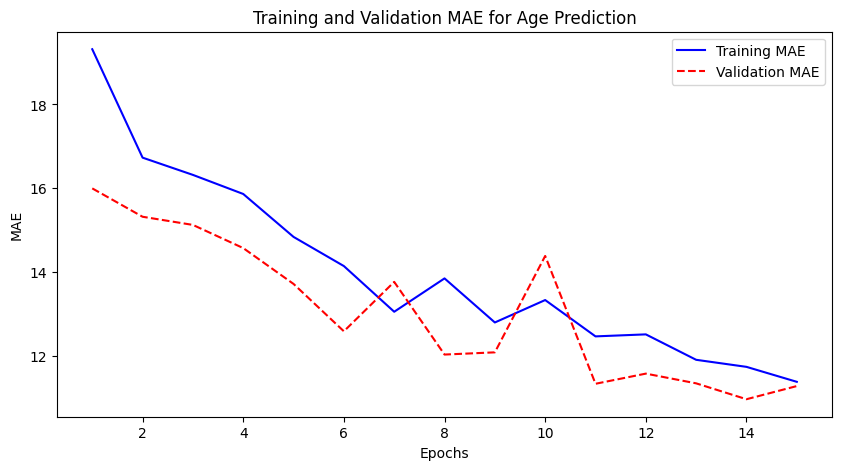

In [68]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history1.history['age_output_mae']
val_loss = history1.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [69]:
# Evaluate on test set
test_results = model_gauss_cnn.evaluate(X_gaussian_test, {'age_output': y_gaussian_age_test, 'gender_output': y_gaussian_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model_gauss_cnn.predict(X_gaussian_test)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_gaussian_gender_test, predicted_gender)
precision = precision_score(y_gaussian_gender_test, predicted_gender)
recall = recall_score(y_gaussian_gender_test, predicted_gender)
f1 = f1_score(y_gaussian_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_gaussian_age_test, predicted_age)
mae = mean_absolute_error(y_gaussian_age_test, predicted_age)
r2 = r2_score(y_gaussian_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - age_output_mae: 11.1046 - gender_output_accuracy: 0.6587 - loss: 221.9614
Test Loss: 217.71865844726562
Age MAE: 11.070695877075195
Gender Accuracy: 0.6775000095367432
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step

Gender Classification Metrics:
Accuracy: 0.6775, Precision: 0.6018518518518519, Recall: 0.7514450867052023, F1 Score: 0.6683804627249358

Age Prediction Metrics:
MSE: 219.5795585246702, MAE: 11.070695187449456, R-squared: 0.40791871276348324


In [70]:
model_mean_cnn = create_cnn(input_shape=(128, 128, 1))  

history2 = model_mean_cnn.fit(
    X_mean_train, {'age_output': y_mean_age_train, 'gender_output': y_mean_gender_train},
    validation_data=(X_mean_val, {'age_output': y_mean_age_val, 'gender_output': y_mean_gender_val}),
    epochs=15,  # Adjust epochs
    batch_size=32)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - age_output_mae: 22.5947 - gender_output_accuracy: 0.5155 - loss: 830.7790 - val_age_output_mae: 16.8957 - val_gender_output_accuracy: 0.4750 - val_loss: 484.9808
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - age_output_mae: 17.1482 - gender_output_accuracy: 0.5301 - loss: 481.2131 - val_age_output_mae: 16.5889 - val_gender_output_accuracy: 0.5250 - val_loss: 426.5513
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - age_output_mae: 17.8634 - gender_output_accuracy: 0.4842 - loss: 524.5413 - val_age_output_mae: 15.6968 - val_gender_output_accuracy: 0.4750 - val_loss: 429.9408
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - age_output_mae: 16.2294 - gender_output_accuracy: 0.4720 - loss: 442.6083 - val_age_output_mae: 16.0513 - val_gender_output_accuracy: 0.5500 - val_loss: 454.5940
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - age_output_mae: 15.9643 - gender_output_accuracy: 0.5012 - loss: 420.3528 - v

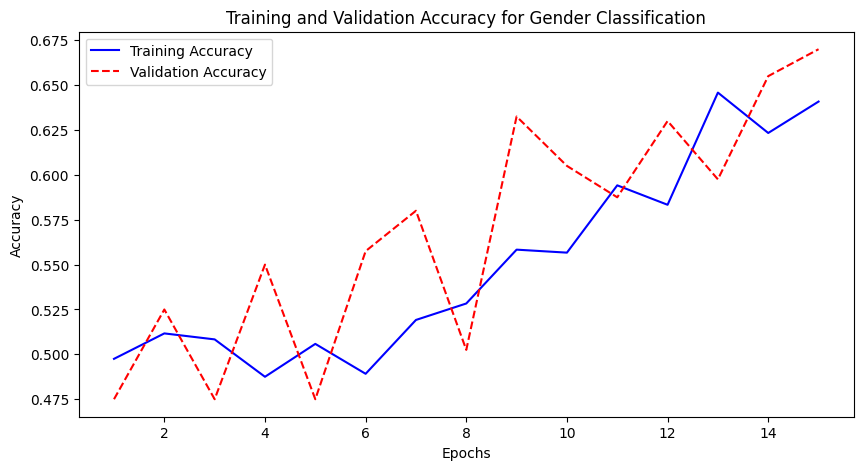

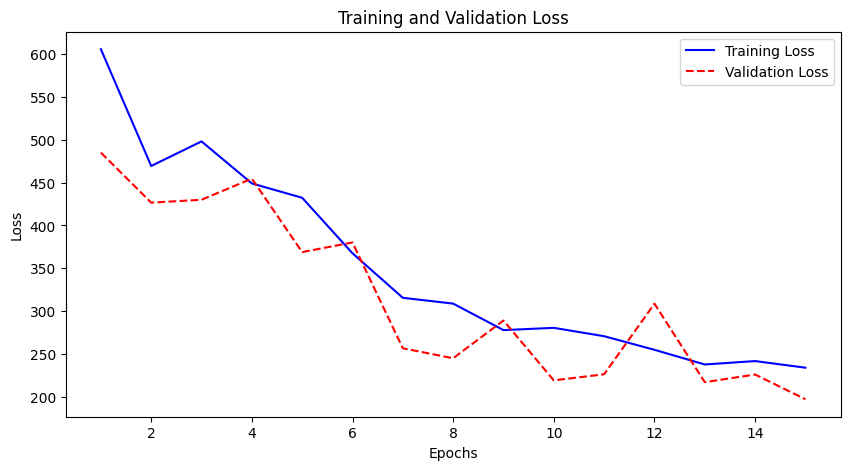

In [71]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history2.history['gender_output_accuracy']
val_acc = history2.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


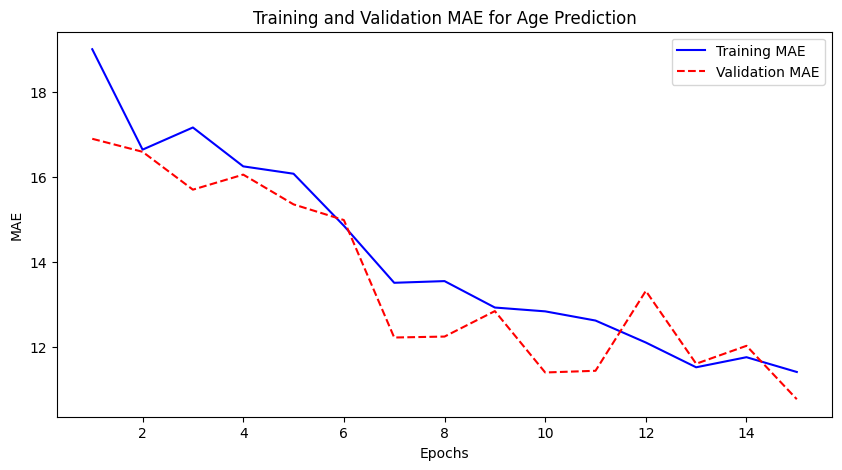

In [72]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history2.history['age_output_mae']
val_loss = history2.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [73]:
# Evaluate on test set
test_results = model_mean_cnn.evaluate(X_mean_test, {'age_output': y_mean_age_test, 'gender_output': y_mean_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model_mean_cnn.predict(X_mean_test)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_mean_gender_test, predicted_gender)
precision = precision_score(y_mean_gender_test, predicted_gender)
recall = recall_score(y_mean_gender_test, predicted_gender)
f1 = f1_score(y_mean_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_mean_age_test, predicted_age)
mae = mean_absolute_error(y_mean_age_test, predicted_age)
r2 = r2_score(y_mean_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - age_output_mae: 10.7325 - gender_output_accuracy: 0.6244 - loss: 205.2932
Test Loss: 198.03305053710938
Age MAE: 10.755383491516113
Gender Accuracy: 0.6549999713897705
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step

Gender Classification Metrics:
Accuracy: 0.655, Precision: 0.5862068965517241, Recall: 0.6878612716763006, F1 Score: 0.6329787234042554

Age Prediction Metrics:
MSE: 202.04785128151468, MAE: 10.75538286715746, R-squared: 0.455191764324952


In [74]:
model_median_cnn = create_cnn(input_shape=(128, 128, 1))  

history3 = model_median_cnn.fit(
    X_median_train, {'age_output': y_median_age_train, 'gender_output': y_median_gender_train},
    validation_data=(X_median_val, {'age_output': y_median_age_val, 'gender_output': y_median_gender_val}),
    epochs=15,  # Adjust epochs
    batch_size=32)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - age_output_mae: 21.3713 - gender_output_accuracy: 0.5064 - loss: 760.1291 - val_age_output_mae: 18.1075 - val_gender_output_accuracy: 0.5250 - val_loss: 537.8832
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 534ms/step - age_output_mae: 17.1828 - gender_output_accuracy: 0.5159 - loss: 501.8551 - val_age_output_mae: 17.4272 - val_gender_output_accuracy: 0.5800 - val_loss: 508.9334
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - age_output_mae: 16.8709 - gender_output_accuracy: 0.5462 - loss: 490.3111 - val_age_output_mae: 15.9721 - val_gender_output_accuracy: 0.4750 - val_loss: 420.9764
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - age_output_mae: 16.3130 - gender_output_accuracy: 0.5171 - loss: 446.4556 - val_age_output_mae: 16.0863 - val_gender_output_accuracy: 0.4750 - val_loss: 455.9096
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - age_output_mae: 16.1623 - gender_output_accuracy: 0.5156 - loss: 446.9028 - v

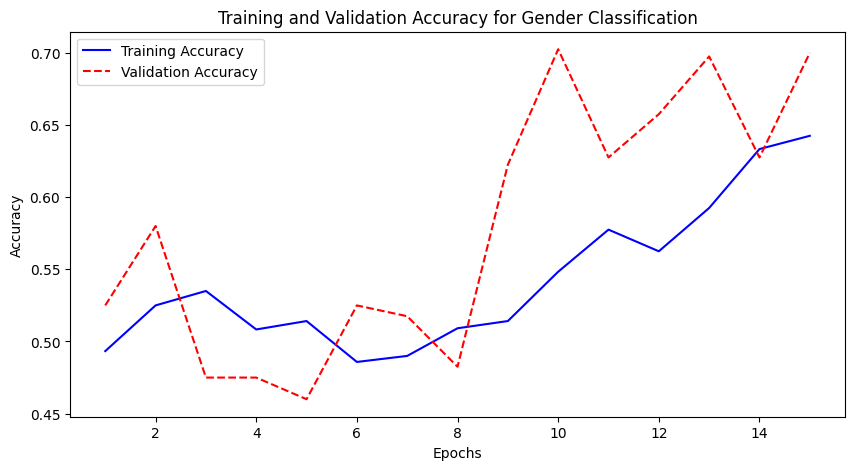

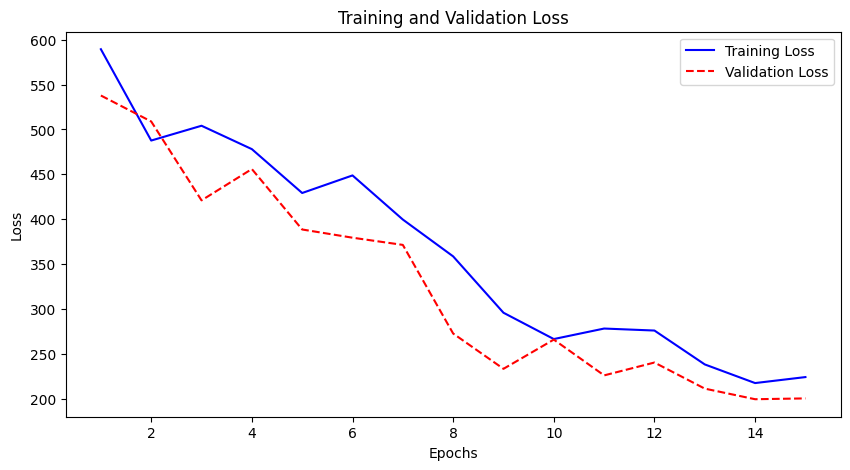

In [75]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history3.history['gender_output_accuracy']
val_acc = history3.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


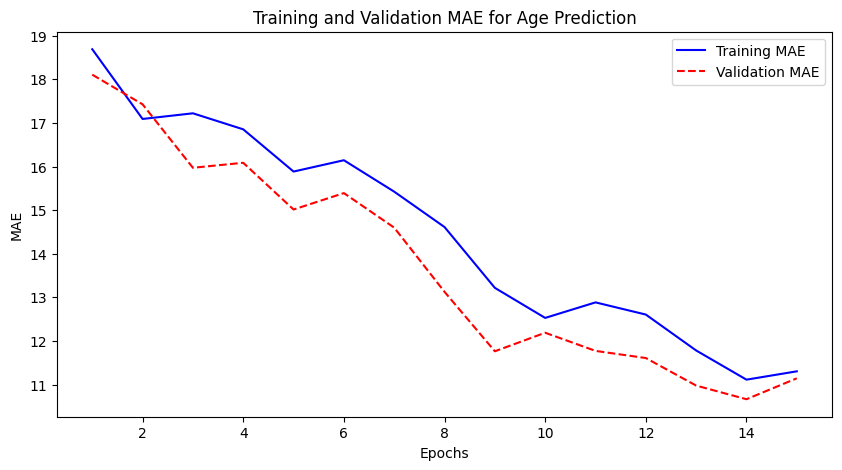

In [76]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history3.history['age_output_mae']
val_loss = history3.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [95]:
# Evaluate on test set
test_results = model_median_cnn.evaluate(X_median_test, {'age_output': y_median_age_test, 'gender_output': y_median_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model_median_cnn.predict(X_median_test)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_median_gender_test, predicted_gender)
precision = precision_score(y_median_gender_test, predicted_gender)
recall = recall_score(y_median_gender_test, predicted_gender)
f1 = f1_score(y_median_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_median_age_test, predicted_age)
mae = mean_absolute_error(y_median_age_test, predicted_age)
r2 = r2_score(y_median_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - age_output_mae: 11.2002 - gender_output_accuracy: 0.6392 - loss: 216.1757
Test Loss: 204.31459045410156
Age MAE: 11.0484037399292
Gender Accuracy: 0.6700000166893005
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

Gender Classification Metrics:
Accuracy: 0.67, Precision: 0.6171428571428571, Recall: 0.6242774566473989, F1 Score: 0.6206896551724138

Age Prediction Metrics:
MSE: 208.53308311672671, MAE: 11.048403731137514, R-squared: 0.43770477947618625


In [86]:
import numpy as np

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

import numpy as np

# Convert grayscale images to RGB format by repeating the grayscale values for each channel
def grayscale_to_rgb(X):
    return np.repeat(X, 3, axis=-1)

# Convert Gaussian filtered images to RGB format
X_gaussian_train_rgb = grayscale_to_rgb(X_gaussian_train)
X_gaussian_val_rgb = grayscale_to_rgb(X_gaussian_val)
X_gaussian_test_rgb = grayscale_to_rgb(X_gaussian_test)

# Convert mean filtered images to RGB format
X_mean_train_rgb = grayscale_to_rgb(X_mean_train)
X_mean_val_rgb = grayscale_to_rgb(X_mean_val)
X_mean_test_rgb = grayscale_to_rgb(X_mean_test)

# Convert median filtered images to RGB format
X_median_train_rgb = grayscale_to_rgb(X_median_train)
X_median_val_rgb = grayscale_to_rgb(X_median_val)
X_median_test_rgb = grayscale_to_rgb(X_median_test)



#### Model Building and Evaluation
##### VGG16 Model

In [87]:
def create_vgg(input_shape):
    # Load pre-trained VGG16 model without the top (fully connected layers)
    base_model = VGG16(weights='/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))  # Adjust input_shape to (height, width, 3)
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    age_output = Dense(1, name='age_output')(x)  # No activation for regression
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)  # Sigmoid for binary classification
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=[age_output, gender_output])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
                  metrics={'age_output': 'mae', 'gender_output': 'accuracy'})
    
    return model



In [136]:
model1_vgg = create_vgg(input_shape=(128, 128, 3))

# Fit the model
history4 = model1_vgg.fit(
    X_train_rgb, {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_data=(X_val_rgb, {'age_output': y_age_val, 'gender_output': y_gender_val}),
    epochs=15,
    batch_size=32
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - age_output_mae: 20.3432 - gender_output_accuracy: 0.5133 - loss: 687.1532 - val_age_output_mae: 14.9371 - val_gender_output_accuracy: 0.5250 - val_loss: 386.5535
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - age_output_mae: 15.5455 - gender_output_accuracy: 0.4934 - loss: 409.6630 - val_age_output_mae: 14.9713 - val_gender_output_accuracy: 0.4750 - val_loss: 372.0833
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - age_output_mae: 14.9423 - gender_output_accuracy: 0.4910 - loss: 374.3324 - val_age_output_mae: 14.8355 - val_gender_output_accuracy: 0.5250 - val_loss: 374.9562
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - age_output_mae: 15.6702 - gender_output_accuracy: 0.5005 - loss: 416.7249 - val_age_output_mae: 14.8929 - val_gender_output_accuracy: 0.5250 - val_loss: 367.7359
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - age_output_mae: 15.1813 - gender_output_accuracy: 0.5305 - loss: 390.9106 - val_age_out

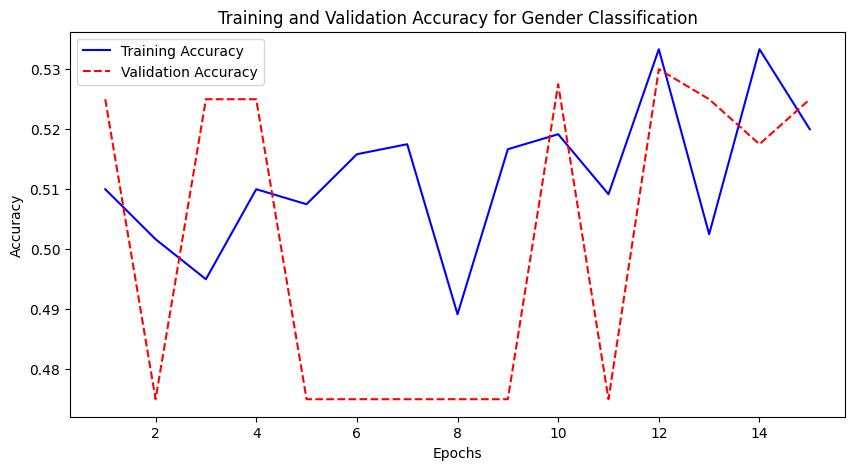

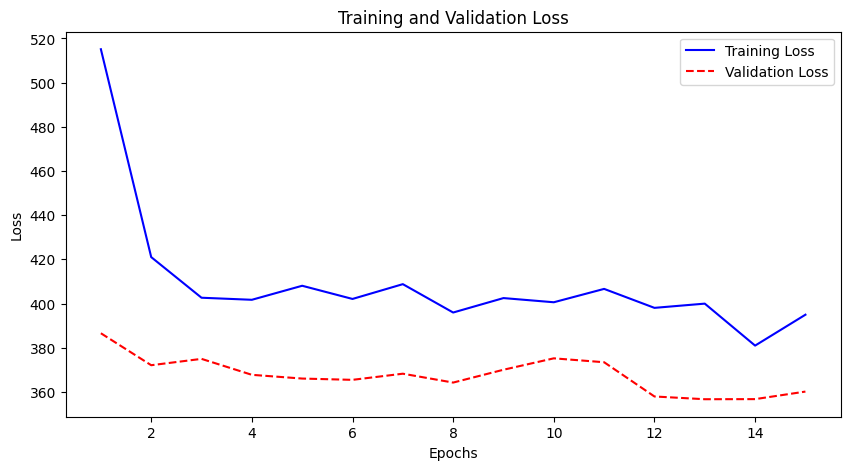

In [137]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history4.history['gender_output_accuracy']
val_acc = history4.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


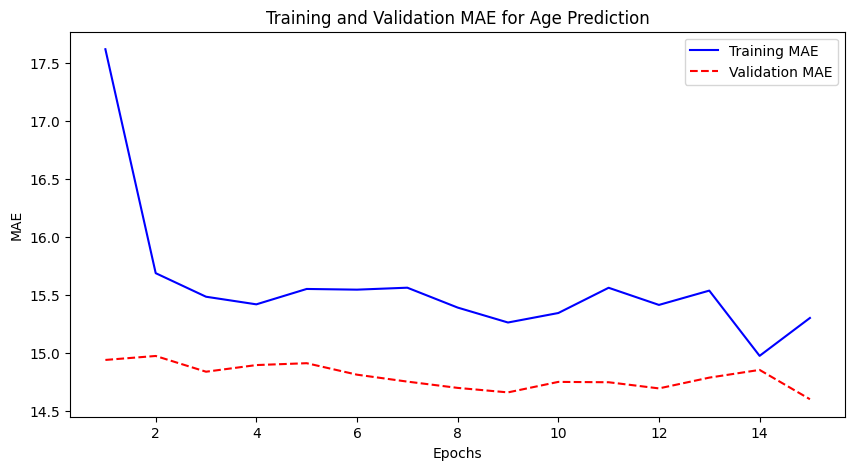

In [138]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history4.history['age_output_mae']
val_loss = history4.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [139]:
# Evaluate on test set
test_results = model1_vgg.evaluate(X_test_rgb, {'age_output': y_age_test, 'gender_output': y_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model1_vgg.predict(X_test_rgb)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_gender_test, predicted_gender)
precision = precision_score(y_gender_test, predicted_gender)
recall = recall_score(y_gender_test, predicted_gender)
f1 = f1_score(y_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_age_test, predicted_age)
mae = mean_absolute_error(y_age_test, predicted_age)
r2 = r2_score(y_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - age_output_mae: 13.6602 - gender_output_accuracy: 0.4342 - loss: 332.6115
Test Loss: 348.22503662109375
Age MAE: 14.181391716003418
Gender Accuracy: 0.4325000047683716
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step

Gender Classification Metrics:
Accuracy: 0.4325, Precision: 0.4325, Recall: 1.0, F1 Score: 0.6038394415357765

Age Prediction Metrics:
MSE: 348.34727704832125, MAE: 14.18139079093933, R-squared: 0.060705351691774156


In [140]:
model2_vgg = create_vgg(input_shape=(128, 128, 3))

# Fit the model
history5 = model2_vgg.fit(
    X_gaussian_train_rgb, {'age_output': y_gaussian_age_train, 'gender_output': y_gaussian_gender_train},
    validation_data=(X_gaussian_val_rgb, {'age_output': y_gaussian_age_val, 'gender_output': y_gaussian_gender_val}),
    epochs=15,
    batch_size=32
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - age_output_mae: 18.5011 - gender_output_accuracy: 0.5081 - loss: 587.0672 - val_age_output_mae: 11.6606 - val_gender_output_accuracy: 0.5150 - val_loss: 236.0154
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - age_output_mae: 11.7870 - gender_output_accuracy: 0.5156 - loss: 231.8928 - val_age_output_mae: 11.1444 - val_gender_output_accuracy: 0.7075 - val_loss: 219.2305
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - age_output_mae: 11.5793 - gender_output_accuracy: 0.5911 - loss: 227.0163 - val_age_output_mae: 10.5537 - val_gender_output_accuracy: 0.7425 - val_loss: 197.3583
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - age_output_mae: 10.5357 - gender_output_accuracy: 0.5833 - loss: 202.7484 - val_age_output_mae: 9.7458 - val_gender_output_accuracy: 0.7800 - val_loss: 174.9359
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - age_output_mae: 9.8177 - gender_output_accuracy: 0.6051 - loss: 164.1725 - val_age_outpu

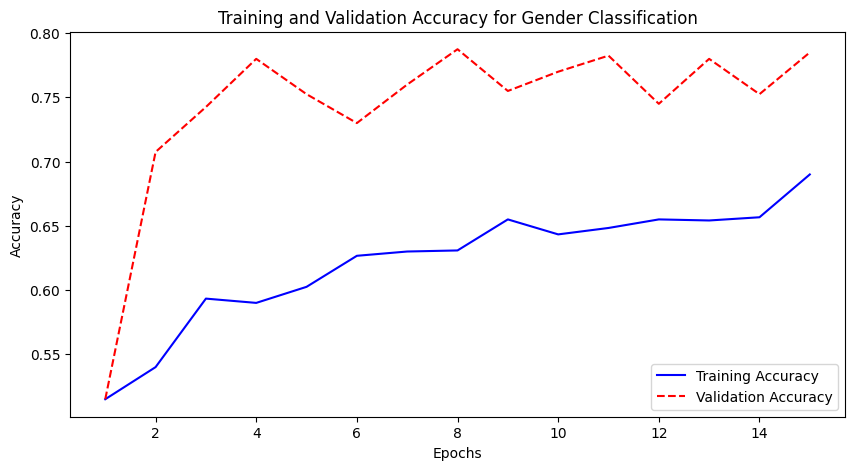

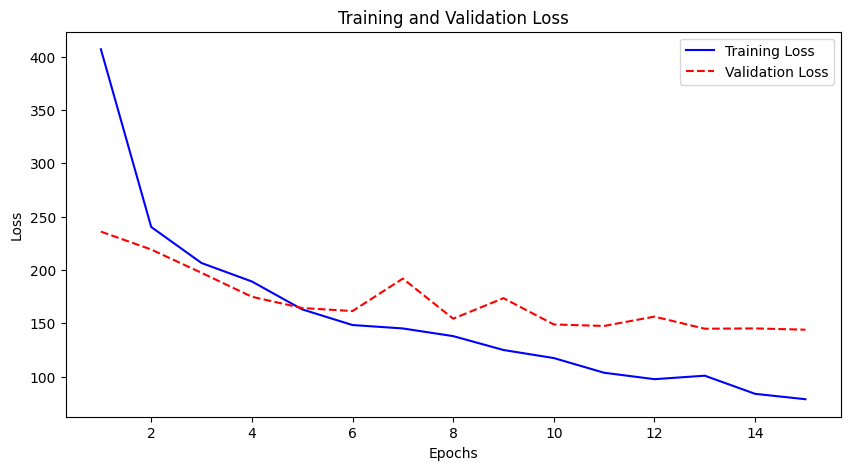

In [141]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history5.history['gender_output_accuracy']
val_acc = history5.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history5.history['loss']
val_loss = history5.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


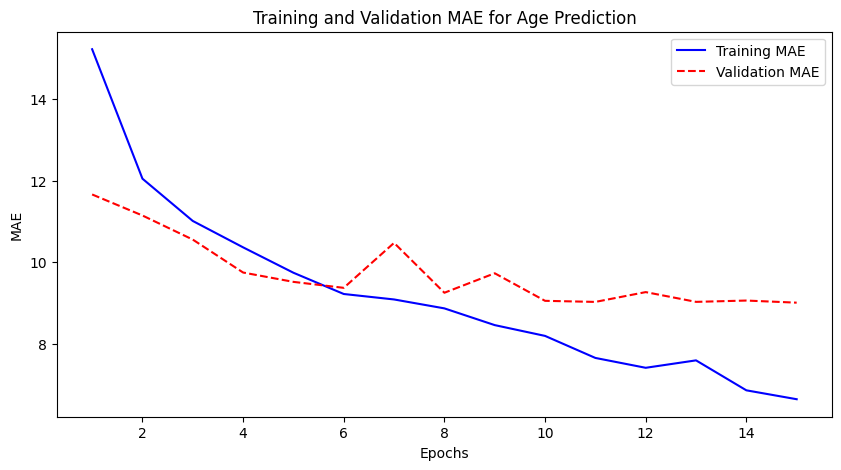

In [142]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history5.history['age_output_mae']
val_loss = history5.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [143]:
# Evaluate on test set
test_results = model2_vgg.evaluate(X_gaussian_test_rgb, {'age_output': y_gaussian_age_test, 'gender_output': y_gaussian_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model2_vgg.predict(X_gaussian_test_rgb)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_gaussian_gender_test, predicted_gender)
precision = precision_score(y_gaussian_gender_test, predicted_gender)
recall = recall_score(y_gaussian_gender_test, predicted_gender)
f1 = f1_score(y_gaussian_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_gaussian_age_test, predicted_age)
mae = mean_absolute_error(y_gaussian_age_test, predicted_age)
r2 = r2_score(y_gaussian_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - age_output_mae: 9.2065 - gender_output_accuracy: 0.7422 - loss: 148.5943
Test Loss: 151.60275268554688
Age MAE: 9.361310958862305
Gender Accuracy: 0.7649999856948853
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step

Gender Classification Metrics:
Accuracy: 0.765, Precision: 0.6945812807881774, Recall: 0.815028901734104, F1 Score: 0.75

Age Prediction Metrics:
MSE: 152.53831444498152, MAE: 9.361310313716531, R-squared: 0.5886908500213324


In [144]:
model3_vgg = create_vgg(input_shape=(128, 128, 3))

# Fit the model
history6 = model3_vgg.fit(
    X_mean_train_rgb, {'age_output': y_mean_age_train, 'gender_output': y_mean_gender_train},
    validation_data=(X_mean_val_rgb, {'age_output': y_mean_age_val, 'gender_output': y_mean_gender_val}),
    epochs=15,
    batch_size=32
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - age_output_mae: 18.5621 - gender_output_accuracy: 0.5087 - loss: 583.0493 - val_age_output_mae: 12.1385 - val_gender_output_accuracy: 0.6375 - val_loss: 249.0545
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - age_output_mae: 12.5936 - gender_output_accuracy: 0.5596 - loss: 259.8716 - val_age_output_mae: 10.8469 - val_gender_output_accuracy: 0.6850 - val_loss: 211.8290
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - age_output_mae: 11.8490 - gender_output_accuracy: 0.5825 - loss: 233.9662 - val_age_output_mae: 10.2012 - val_gender_output_accuracy: 0.6050 - val_loss: 190.6956
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - age_output_mae: 11.0905 - gender_output_accuracy: 0.5520 - loss: 206.8577 - val_age_output_mae: 10.1174 - val_gender_output_accuracy: 0.7450 - val_loss: 187.1781
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - age_output_mae: 9.9904 - gender_output_accuracy: 0.6032 - loss: 175.2492 - val_age_outp

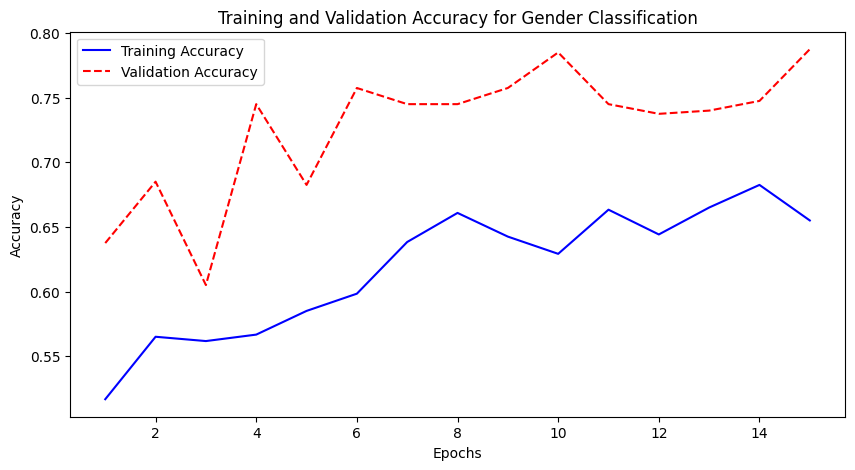

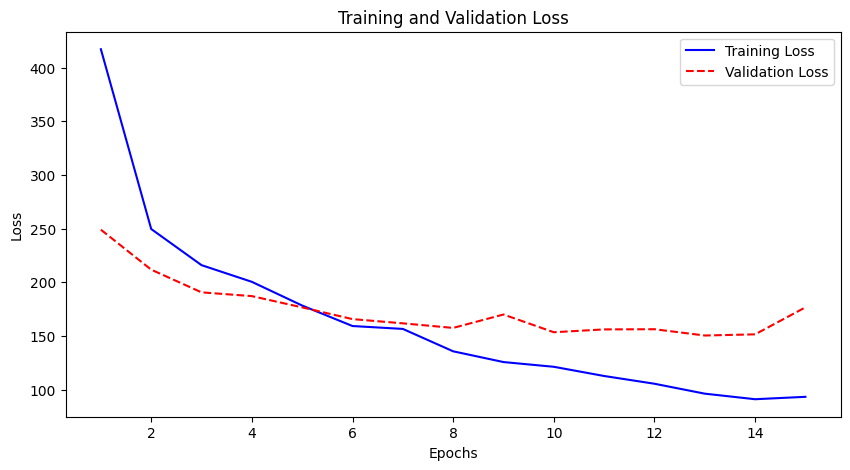

In [145]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history6.history['gender_output_accuracy']
val_acc = history6.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history6.history['loss']
val_loss = history6.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


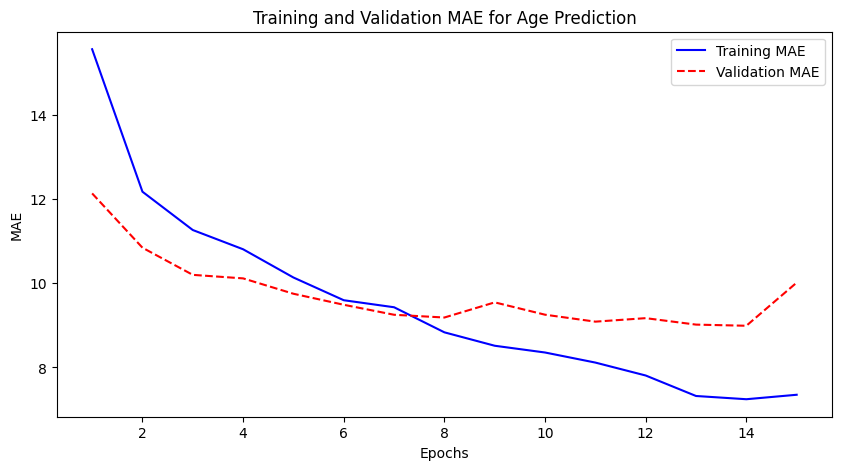

In [146]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history6.history['age_output_mae']
val_loss = history6.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [147]:
# Evaluate on test set
test_results = model3_vgg.evaluate(X_mean_test_rgb, {'age_output': y_mean_age_test, 'gender_output': y_mean_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model3_vgg.predict(X_mean_test_rgb)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_mean_gender_test, predicted_gender)
precision = precision_score(y_mean_gender_test, predicted_gender)
recall = recall_score(y_mean_gender_test, predicted_gender)
f1 = f1_score(y_mean_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_mean_age_test, predicted_age)
mae = mean_absolute_error(y_mean_age_test, predicted_age)
r2 = r2_score(y_mean_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - age_output_mae: 10.0671 - gender_output_accuracy: 0.7673 - loss: 173.4683
Test Loss: 180.31761169433594
Age MAE: 10.245654106140137
Gender Accuracy: 0.7774999737739563
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step

Gender Classification Metrics:
Accuracy: 0.7775, Precision: 0.7413793103448276, Recall: 0.7456647398843931, F1 Score: 0.7435158501440922

Age Prediction Metrics:
MSE: 179.84167484003308, MAE: 10.245655152201653, R-squared: 0.5150692029190207


In [148]:
model4_vgg = create_vgg(input_shape=(128, 128, 3))

# Fit the model
history7 = model4_vgg.fit(
    X_median_train_rgb, {'age_output': y_median_age_train, 'gender_output': y_median_gender_train},
    validation_data=(X_median_val_rgb, {'age_output': y_median_age_val, 'gender_output': y_median_gender_val}),
    epochs=15,
    batch_size=32
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - age_output_mae: 19.4410 - gender_output_accuracy: 0.5140 - loss: 633.2921 - val_age_output_mae: 11.8027 - val_gender_output_accuracy: 0.6500 - val_loss: 249.1990
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - age_output_mae: 12.2647 - gender_output_accuracy: 0.5056 - loss: 250.8137 - val_age_output_mae: 11.0257 - val_gender_output_accuracy: 0.7075 - val_loss: 217.7218
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - age_output_mae: 12.0689 - gender_output_accuracy: 0.5852 - loss: 241.5426 - val_age_output_mae: 10.1646 - val_gender_output_accuracy: 0.7050 - val_loss: 188.7530
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - age_output_mae: 10.6902 - gender_output_accuracy: 0.6278 - loss: 200.8190 - val_age_output_mae: 10.1230 - val_gender_output_accuracy: 0.6975 - val_loss: 181.2307
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - age_output_mae: 10.0998 - gender_output_accuracy: 0.5949 - loss: 177.4108 - val_age_out

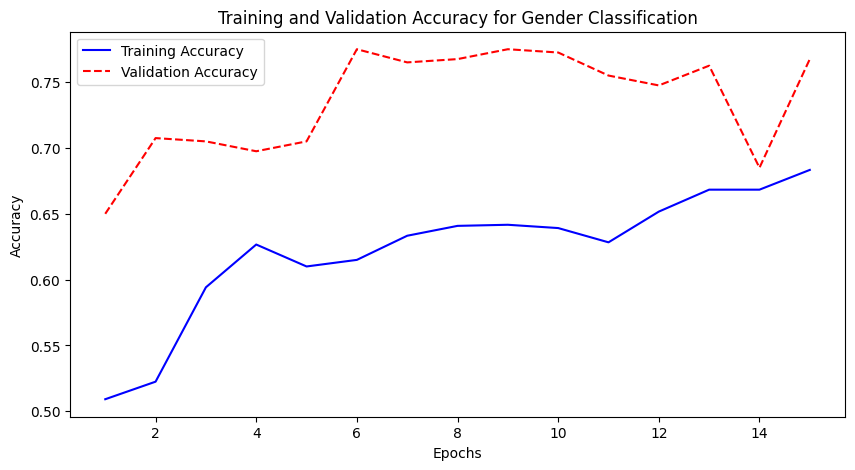

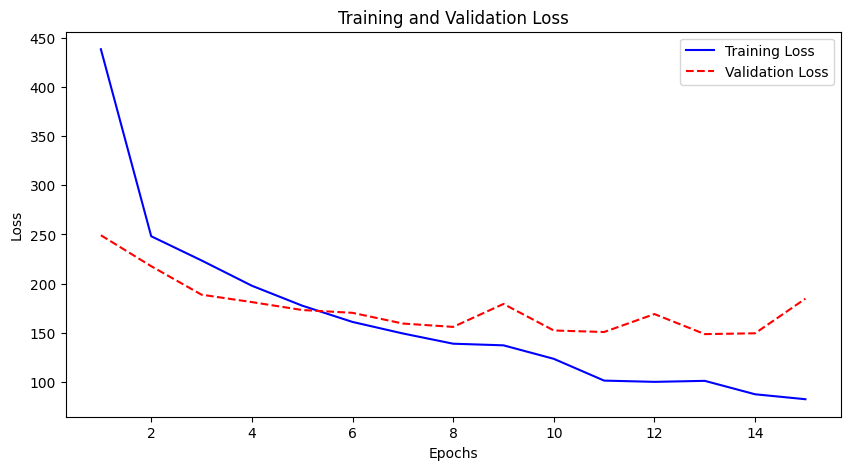

In [149]:
import matplotlib.pyplot as plt

# Corrected keys based on your model's output
acc = history7.history['gender_output_accuracy']
val_acc = history7.history['val_gender_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation Accuracy for Gender Classification
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))

loss = history7.history['loss']
val_loss = history7.history['val_loss']

# Plotting Training and Validation Loss
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


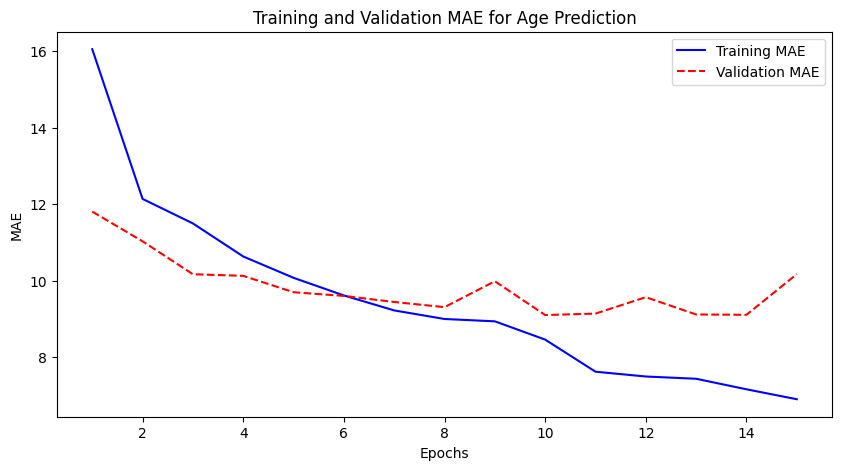

In [150]:
import matplotlib.pyplot as plt

# Corrected keys for age prediction Mean Absolute Error (MAE)
loss = history7.history['age_output_mae']
val_loss = history7.history['val_age_output_mae']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plotting Training and Validation MAE for Age Prediction
plt.plot(epochs, loss, 'b-', label='Training MAE')
plt.plot(epochs, val_loss, 'r--', label='Validation MAE')
plt.title('Training and Validation MAE for Age Prediction')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [151]:
# Evaluate on test set
test_results = model4_vgg.evaluate(X_median_test_rgb, {'age_output': y_median_age_test, 'gender_output': y_median_gender_test})
print(f"Test Loss: {test_results[0]}")
print(f"Age MAE: {test_results[1]}")
print(f"Gender Accuracy: {test_results[2]}")

# Predictions for metrics calculation
predictions = model4_vgg.predict(X_median_test_rgb)
predicted_age = predictions[0].flatten()
predicted_gender = (predictions[1] > 0.5).astype(int).flatten()

# Gender classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(y_median_gender_test, predicted_gender)
precision = precision_score(y_median_gender_test, predicted_gender)
recall = recall_score(y_median_gender_test, predicted_gender)
f1 = f1_score(y_median_gender_test, predicted_gender)

# Age prediction metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_median_age_test, predicted_age)
mae = mean_absolute_error(y_median_age_test, predicted_age)
r2 = r2_score(y_median_age_test, predicted_age)

# Print metrics
print("\nGender Classification Metrics:")
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

print("\nAge Prediction Metrics:")
print(f"MSE: {mse}, MAE: {mae}, R-squared: {r2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - age_output_mae: 10.2753 - gender_output_accuracy: 0.7445 - loss: 179.5686
Test Loss: 188.01573181152344
Age MAE: 10.409736633300781
Gender Accuracy: 0.7400000095367432
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step

Gender Classification Metrics:
Accuracy: 0.74, Precision: 0.7315436241610739, Recall: 0.630057803468208, F1 Score: 0.6770186335403726

Age Prediction Metrics:
MSE: 187.16692650282278, MAE: 10.409736776351929, R-squared: 0.4953171619595764
